In [34]:
import pandas as pd
import numpy as np
import re
import nltk
import mlflow
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# ===============================
# Setup
# ===============================
nltk.download('stopwords')
nltk.download('wordnet')

important_stopwords = {'not', 'no', 'never', 'but', 'yet', 'however', 'because', 'since', 'if', 'when', 'while', 'unless', 'until', 'still', 'despite', 'though'}
stop_words = set(stopwords.words('english')) - important_stopwords
lemmatizer = WordNetLemmatizer()

mlflow.set_tracking_uri("http://ec2-35-177-151-168.eu-west-2.compute.amazonaws.com:5000")
mlflow.set_experiment("Baseline_ML_Experiment")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/santoshkumarguntupalli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/santoshkumarguntupalli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<Experiment: artifact_location='s3://sentiment-analysis-mlops-08052025/532549804044274163', creation_time=1746701976820, experiment_id='532549804044274163', last_update_time=1746701976820, lifecycle_stage='active', name='Baseline_ML_Experiment', tags={}>

In [36]:
# ===============================
# Text Cleaning
# ===============================
def clean_text(text):
    text = text.lower().strip()
    text = re.sub(r'http[s]?://\S+|httpst\.[a-zA-Z0-9]+', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^A-Za-z0-9\s!?.,]', '', text)
    words = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return ' '.join(words)

In [37]:
# ===============================
# Load Data
# ===============================
df = pd.read_csv("financial_tweets.csv")
df = df.drop(columns=["Unnamed: 0", "url"], errors="ignore")
df['tweet'] = df['tweet'].apply(clean_text)

X = df['tweet']
y = df['sentiment']

In [38]:
# ===============================
# Train-Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [39]:
# ===============================
# Vectorization
# ===============================
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

2025/05/08 13:37:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run overjoyed-shoat-192 at: http://ec2-35-177-151-168.eu-west-2.compute.amazonaws.com:5000/#/experiments/532549804044274163/runs/e38f38ab96d14942a52e081deb6bd685
🧪 View experiment at: http://ec2-35-177-151-168.eu-west-2.compute.amazonaws.com:5000/#/experiments/532549804044274163
Logistic Regression baseline complete. Accuracy: 0.7271295445596535


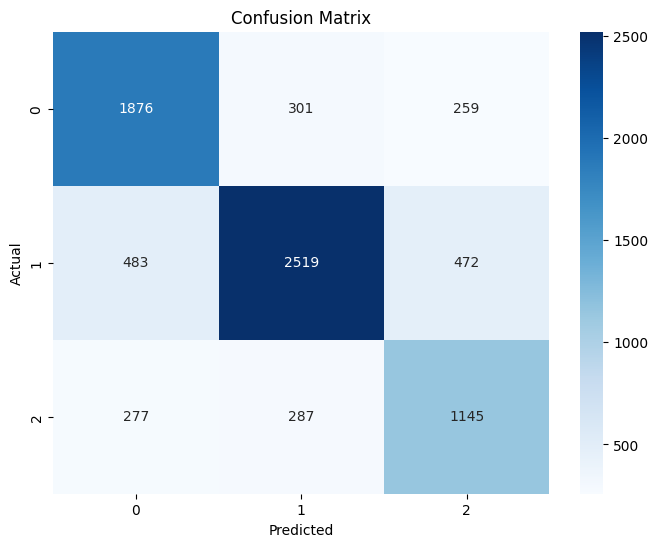

In [40]:
# ----------------------
# Model Training + MLflow
# ----------------------
with mlflow.start_run():
    mlflow.set_tag("pipeline", "baseline_tfidf_lr")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "Logistic Regression")

    # Add a description
    mlflow.set_tag("description", "Baseline LR model for sentiment analysis using tf-idf")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "TfidfVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log LR model parameters
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("C", 1.0)
    mlflow.log_param("penalty", "l2")

    # Initialize and train the LR model
    model = LogisticRegression(
        class_weight="balanced",
        C=1.0,
        penalty="l2",
        max_iter=1000,
        solver="lbfgs",
        random_state=42
    )
    model.fit(X_train_vec, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_vec)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    # Classification report logging
    report = classification_report(y_test, y_pred, output_dict=True)
    for label, scores in report.items():
        if isinstance(scores, dict):
            for metric, score in scores.items():
                mlflow.log_metric(f"{label}_{metric}", score)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    
    # Save and log the confusion matrix plot
    fig.savefig("conf_matrix_lr.png")
    mlflow.log_artifact("conf_matrix_lr.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "logistic_regression_model")

    #log the dataset
    df.to_csv("financial_tweets_cleaned.csv", index=False)
    mlflow.log_artifact("financial_tweets_cleaned.csv")

# Display final accuracy
print("Logistic Regression baseline complete. Accuracy:", accuracy)

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74      2436
           1       0.81      0.73      0.77      3474
           2       0.61      0.67      0.64      1709

    accuracy                           0.73      7619
   macro avg       0.71      0.72      0.71      7619
weighted avg       0.73      0.73      0.73      7619

